## Create and test ion channel model

In [1]:
import numpy as np
import pyabc
import matplotlib.pyplot as plt

In [2]:
import pyabc
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from ionchannelABC.visualization import plot_sim_results

In [4]:
from experiments.whole_cell import ap

In [5]:
from ionchannelABC.experiment import setup

In [6]:
modelfile = 'models/HL1.mmt'

In [7]:
prev_runs = ['ina/hl1_ina.db',
             'ical/hl1_ical.db',
             'icat/hl1_icat.db',
             'iha/hl1_iha.db',
             'ik1/hl1_ik1.db',
             'ikr/hl1_ikr.db',
             'ito/hl1_ito.db',
             'ikss/hl1_ikss.db']
prev_runs = ['sqlite:///results_db/'+path
             for path in prev_runs]

In [8]:
# include uncertainty in membrane capacitance
additional_pars = {'membrane.Cm': pyabc.RV("norm", loc=13.7, scale=(np.sqrt(12)*1.4))}
additional_pars = pyabc.Distribution(additional_pars)

In [9]:
observations, model, summary_statistics = setup(modelfile, ap, 
                                                pacevar='engine.pace',
                                                tvar='phys.T',
                                                logvars=['membrane.V','calcium.Ca_i','engine.time'],
                                                prev_runs=prev_runs,
                                                timeout=5,
                                                additional_pars=additional_pars)

In [10]:
assert(len(observations)==len(summary_statistics(model({}))))

In [11]:
summary_statistics(model({}))

{'0': inf, '1': inf, '2': inf, '3': inf, '4': inf, '5': inf, '6': inf}

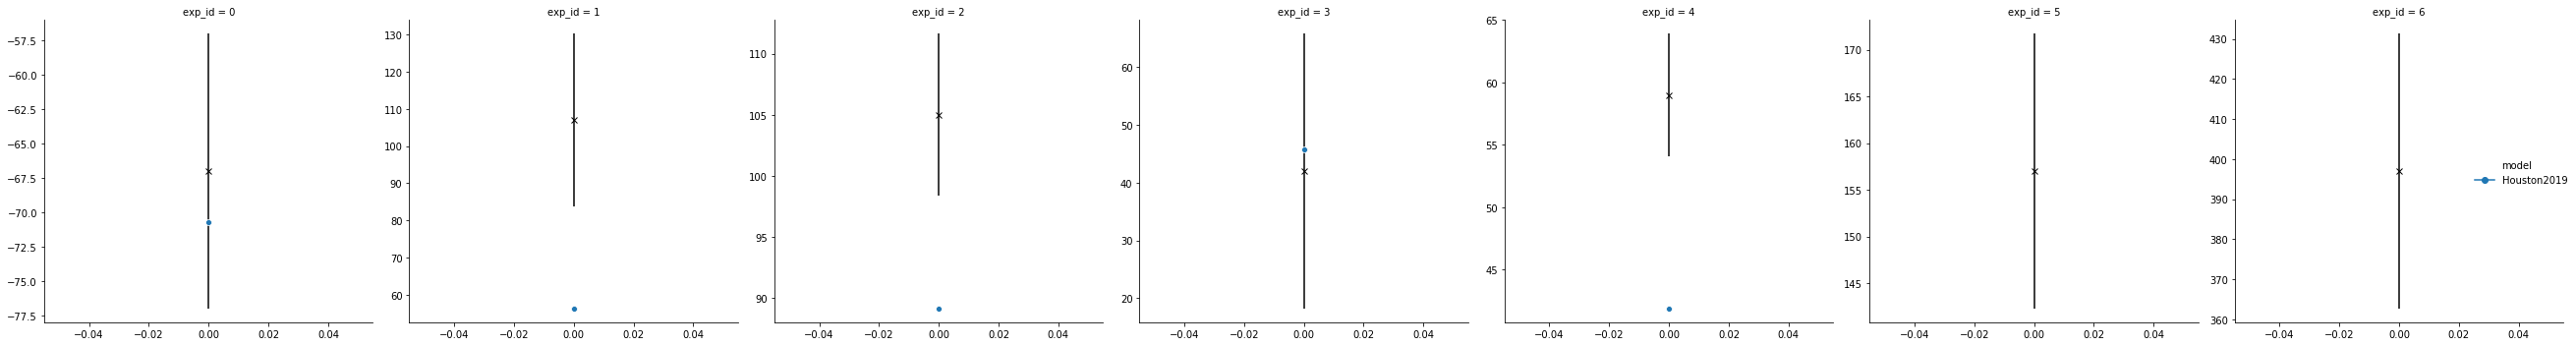

In [12]:
from ionchannelABC import plot_sim_results
g = plot_sim_results(modelfile, ap, 
                     pacevar='engine.pace', 
                     tvar='phys.T', 
                     additional_pars=additional_pars,
                     prev_runs=prev_runs)

## Set limits and generate uniform initial priors

In [13]:
from pyabc import Distribution, RV
limits = {#'cell.V_SR': (0, 0.1), # volume of sarcoplasmic reticulum
          #'log_calcium_sr.Buf_tot': (0, 6.), # calcium buffering in SR (total)
          #'log_calcium_sr.Km_Buf': (0, 3.), # calcium buffering in SR (Km)
          'log_tr.tau_tr': (0, 3.), # time constant for calcium diffusion
          'serca.V_max': (0, 1.), # maximum velocity of SERCA calcium uptake
          'log_leak.k_leak': (-7, -5), # maximum conductance of leak calcium current
          'ryr.k_RyR': (0, 0.1), # maximum conductance of ryanodine receptor current
          #'icab.g_Cab': (0, 0.01), # maximum conductance of background calcium currents
          'inab.g_Nab': (0, 0.01), # maximum conductance of background sodium currents
          'incx.k_NCX': (0, 10), # maximum conductance of Na-Ca exchange current
          'inak.i_NaK_max': (0, 10), # maxmimum conductance of Na-K pump current
          #'ipca.g_pCa': (0, 0.1), # maximum conductance of calcium pump current
          'log_diff.tau_diff': (-3, -1), # cytosolic calcium diffusion coefficient
          #'calcium.D_Ca': (0, 1e2), # cytosolic calcium diffusion coefficient
          #'calcium.Buf_tot': (0, 1e2), # calcium buffering in cytosol
          #'calcium.Km_Buf': (0, 10), # calcium buffer in cytosol (Km)
          #'ical.k_fCass': (0, 10), # steady-state calcium current
          'ical.Km_fCa': (0, 1.), # ical calcium dissociation constant (uM)
          'log_ical.a_fCa': (-3, -1), # ical calcium dissociation rate (ms^-1)
         }
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [14]:
summary_statistics(model(prior.rvs()))

{'0': -0.9931513401945862,
 '1': 0.7340570967670622,
 '2': 0.8812505832598643,
 '3': 1.5070591177108803,
 '4': 1.049317903300477,
 '5': 2.239105818991158,
 '6': 1.4066346437928046}

## Run ABC calibration

In [15]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "whole_cell.db"))

In [16]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [17]:
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [18]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=10),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.742034919710861, '1': 0.5104332251839483, '2': 1.753123460328047, '3': 0.19534724991847946, '4': 1.3338160267724242, '5': 1.1831023514309071, '6': 1.2821427666553327}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=10, quantile_multiplier=1


In [19]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [20]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-12-09 16:10:46.681988, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=30, min_acceptance_rate=0.001)

INFO:ABC:t: 0, eps: 10.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 4525.
INFO:ABC:Acceptance rate: 2000 / 4525 = 4.4199e-01.
DEBUG:Epsilon:new eps, t=1, eps=1.1593317542033812
INFO:ABC:t: 1, eps: 1.1593317542033812.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 11794.
INFO:ABC:Acceptance rate: 2000 / 7269 = 2.7514e-01.
DEBUG:Epsilon:new eps, t=2, eps=0.8304516734062315
INFO:ABC:t: 2, eps: 0.8304516734062315.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 24958.
INFO:ABC:Acceptance rate: 2000 / 13164 = 1.5193e-01.
DEBUG:Epsilon:new eps, t=3, eps=0.6362158921812029
INFO:ABC:t: 3, eps: 0.6362158921812029.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 47478.
INFO:ABC:Acceptance rate: 2000 / 22520 = 8.8810e-02.
DEBUG:Epsilon:new eps, t=4, eps=0.529253472687

In [27]:
abc_continued = ABCSMC(models=model,
                       parameter_priors=prior,
                       distance_function=IonChannelDistance(
                           exp_id=list(observations.exp_id),
                           variance=list(observations.variance),
                           delta=0.05),
                       population_size=ConstantPopulationSize(1000),
                       summary_statistics=summary_statistics,
                       transitions=EfficientMultivariateNormalTransition(),
                       eps=MedianEpsilon(),
                       sampler=MulticoreEvalParallelSampler(n_procs=16),
                       acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.742034919710861, '1': 0.5104332251839483, '2': 1.753123460328047, '3': 0.19534724991847946, '4': 1.3338160267724242, '5': 1.1831023514309071, '6': 1.2821427666553327}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [28]:
abc_continued.load(db_path, 1)

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=20, min_acceptance_rate=0.0001)

INFO:Epsilon:initial epsilon is 0.3218909654363851
INFO:ABC:t: 13, eps: 0.3218909654363851.
DEBUG:ABC:Now submitting population 13.


# Results analysis

In [16]:
from pyabc import History

In [17]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-12-05 14:01:22.376555, end_time=2019-12-07 20:45:45.823088)>]

In [18]:
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,inab.g_Nab,inak.i_NaK_max,incx.k_NCX,log_diff.tau_diff,log_leak.k_leak,log_tr.tau_tr,ryr.k_RyR,serca.V_max
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.007321,8.236092,5.811285,-2.546627,-5.999024,1.472639,0.041089,0.279715
std,0.001723,1.128965,1.666249,0.263168,0.520087,0.795591,0.029986,0.250700
min,0.000682,4.333648,1.976099,-2.996833,-6.998181,0.002549,0.000054,0.000282
25%,0.006232,7.550422,4.477041,-2.756689,-6.433161,0.835805,0.013488,0.090230
50%,0.007544,8.405650,5.656767,-2.573838,-5.994434,1.416461,0.038126,0.196855
75%,0.008706,9.110542,7.022607,-2.368041,-5.592335,2.135698,0.066078,0.388958
max,0.009996,9.999970,9.921333,-1.758854,-5.001104,2.996012,0.099907,0.990994


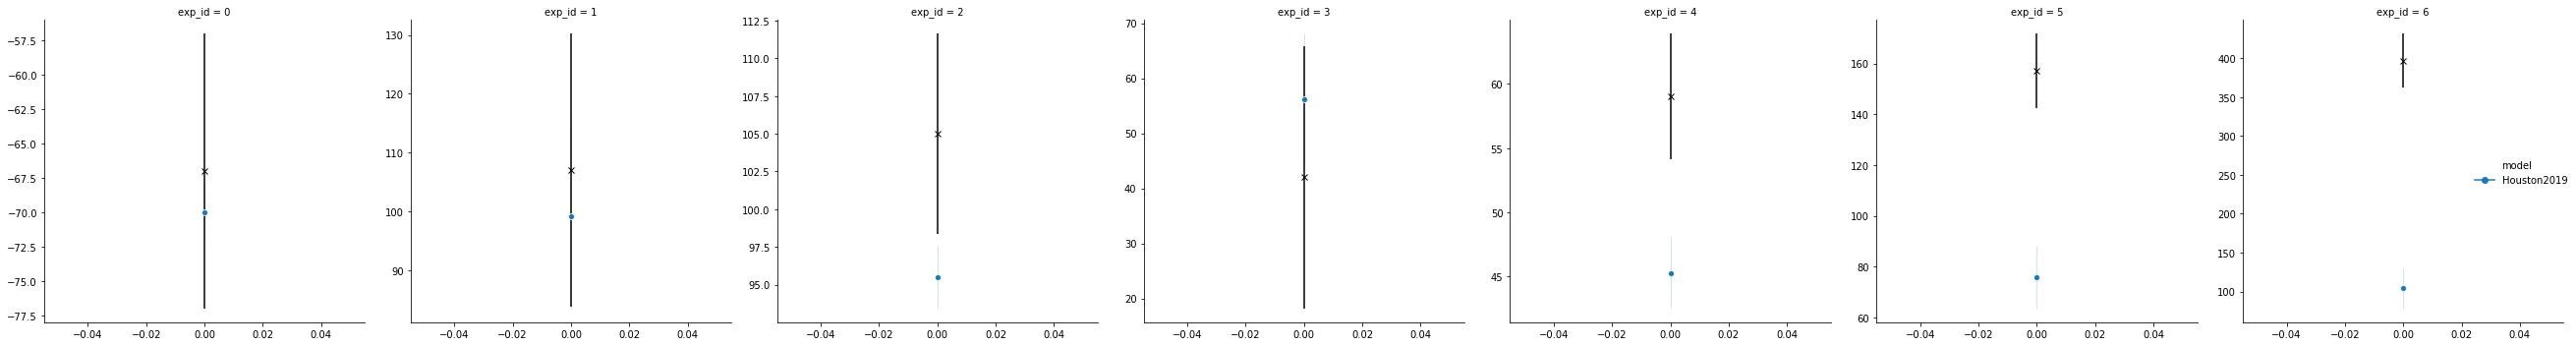

In [21]:
g = plot_sim_results(modelfile, ap, 
                     pacevar='engine.pace', 
                     tvar='phys.T',
                     prev_runs=prev_runs,
                     df=df, w=w,
                     exclude_infs=True)

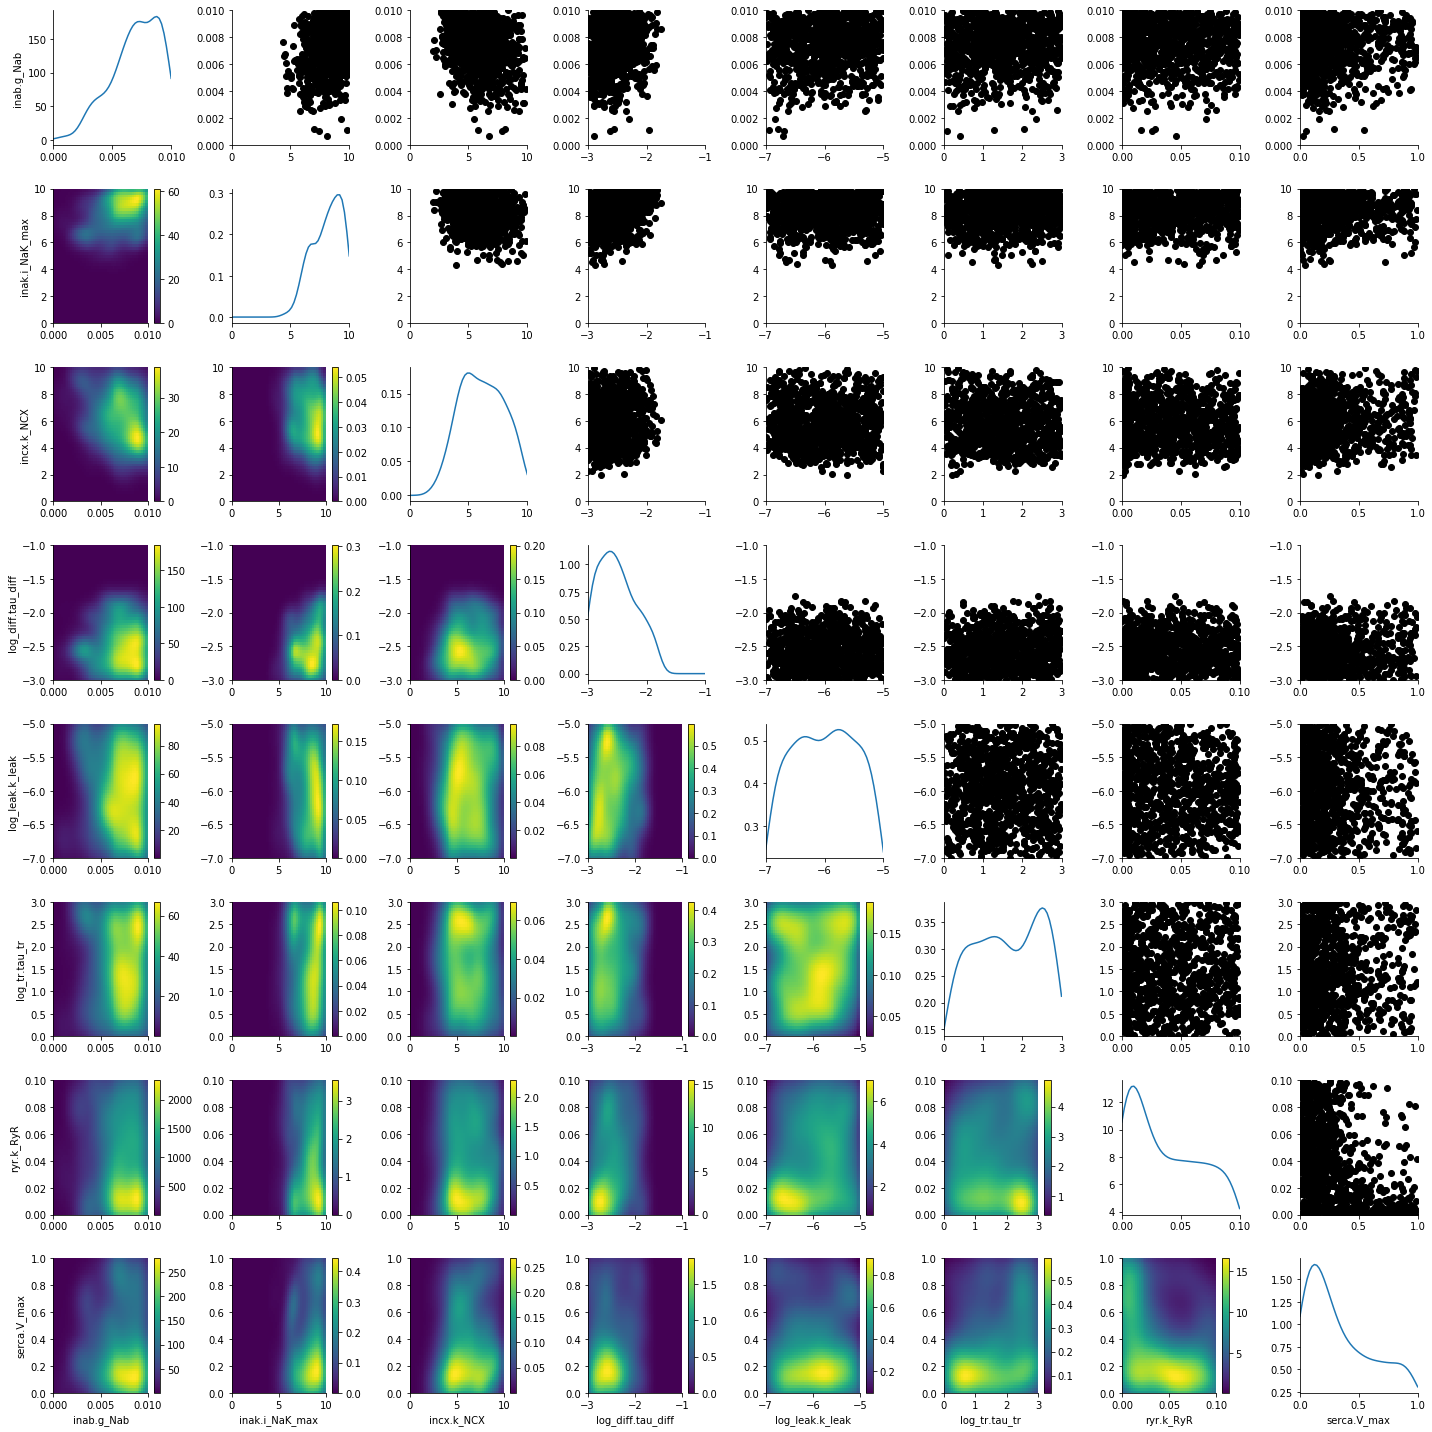

In [22]:
from ionchannelABC.visualization import plot_kde_matrix_custom
g = plot_kde_matrix_custom(df, w, limits=limits)

# Samples for quantitative analysis

In [ ]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [ ]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)